# Fine-tuning the embedding model

In this notebook we create out Custom Embedding Model by using MLR loss optimisation 

*(Note: This notebook was run in Google Collab. I have simply changed name imports.)*

## Module Imports



In [ ]:
!pip install datasets transformers sentence-transformers

In [ ]:
import pandas as pd
from datasets import Dataset

from transformers import BertTokenizer, AutoTokenizer

import sentence_transformers
from sentence_transformers import InputExample
from sentence_transformers import datasets as st_datasets
from sentence_transformers import models, SentenceTransformer
from sentence_transformers import losses
from transformers import AutoModel

import torch

from tqdm.auto import tqdm

## Creating Dataset

In [ ]:
data_path = 'datasets/verses_org.csv'
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,id,verse_number,chapter_number,slug,text,transliteration,word_meanings,translations,commentaries
0,0,624,1,18,chapter-18-verse-1,अर्जुन उवाच\n\nसंन्यासस्य महाबाहो तत्त्वमिच्छा...,arjuna uvācha\nsannyāsasya mahā-bāho tattvam i...,arjunaḥ uvācha—Arjun said; sanyāsasya—of renun...,"Arjuna said, ""I desire to know the truth about...","The sentence in English translation is:\n\n""Th..."
1,1,625,2,18,chapter-18-verse-2,श्री भगवानुवाच\n\nकाम्यानां कर्मणां न्यासं संन...,śhrī-bhagavān uvācha\nkāmyānāṁ karmaṇāṁ nyāsaṁ...,śhrī-bhagavān uvācha—the Supreme Divine Person...,Hindi Translation By Swami Ramsukhdas,Here is the translation of the given sentence ...
2,2,626,3,18,chapter-18-verse-3,त्याज्यं दोषवदित्येके कर्म प्राहुर्मनीषिणः।\n\...,tyājyaṁ doṣha-vad ity eke karma prāhur manīṣhi...,tyājyam—should be given up; doṣha-vat—as evil;...,Some philosophers declare that actions should ...,Here is the translation of the given sentence ...
3,3,627,4,18,chapter-18-verse-4,निश्चयं श्रृणु मे तत्र त्यागे भरतसत्तम।त्यागो ...,niśhchayaṁ śhṛiṇu me tatra tyāge bharata-satta...,niśhchayam—conclusion; śhṛiṇu—hear; me—my; tat...,O the most excellent among the descendants of ...,Here is the translation of the given sentence ...
4,4,628,5,18,chapter-18-verse-5,यज्ञदानतपःकर्म न त्याज्यं कार्यमेव तत्।यज्ञो द...,yajña-dāna-tapaḥ-karma na tyājyaṁ kāryam eva t...,yajña—sacrifice; dāna—charity; tapaḥ—penance; ...,"(a) The acts of sacrifice, gifts, and austerit...",Here are the translations of the Hindi words a...


In [ ]:
ds = []

for _, row in df.iterrows():

    # QA pair for chapters
    ds.append({'premise': f'What is the shloka in sanskrit of Chapter {row.chapter_number} Verse {row.verse_number}',
    'hypothesis':f'{row.text}',
    'label':'1'
    })

    ds.append({'premise': f'What is the verse in sanskrit of Chapter {row.chapter_number} Verse {row.verse_number}',
    'hypothesis':f'{row.text}',
    'label':'1'
    })

    ds.append({'premise': f'What is the verse in English of Chapter {row.chapter_number} Verse {row.verse_number}',
    'hypothesis':f'{row.transliteration}',
    'label':'1'
    })

    ds.append({'premise': f'What is the shloka in English of Chapter {row.chapter_number} Verse {row.verse_number}',
    'hypothesis':f'{row.transliteration}',
    'label':'1'
    })

    # QA pairs for commentaries
    ds.append({'premise': f'What does  {row.chapter_number} Verse {row.verse_number} say?',
    'hypothesis':f'{row.commentaries}',
    'label':'2'
    })

    ds.append({'premise': f'What does  {row.text} explain?',
    'hypothesis':f'{row.commentaries}',
    'label':'2'
    })

    # Cross Translation
    ds.append({'premise': f'What does {row.text} mean in sanskirt',
    'hypothesis':f'{row.translations}',
    'label':'3'
    })

    ds.append({'premise': f'What does {row.translations} mean in english',
    'hypothesis':f'{row.text}',
    'label':'3'
    })

dataset_df = pd.DataFrame(ds)
dataset_df.head()


,premise,hypothesis,label
0,What is the shloka in sanskrit of Chapter 18 V...,अर्जुन उवाच\n\nसंन्यासस्य महाबाहो तत्त्वमिच्छा...,1
1,What is the verse in sanskrit of Chapter 18 Ve...,अर्जुन उवाच\n\nसंन्यासस्य महाबाहो तत्त्वमिच्छा...,1
2,What is the verse in English of Chapter 18 Ver...,arjuna uvācha\nsannyāsasya mahā-bāho tattvam i...,1
3,What is the shloka in English of Chapter 18 Ve...,arjuna uvācha\nsannyāsasya mahā-bāho tattvam i...,1
4,What does 18 Verse 1 say?,"The sentence in English translation is:\n\n""Th...",2


In [ ]:
dataset = Dataset.from_pandas(dataset_df)
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 5608
})

## Processing Dataset

Transforming Text and loading into `Dataset` format

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
dataset = dataset.map(
    lambda x: tokenizer(
            x['premise'], max_length=128, padding='max_length',
            truncation=True
        ), batched=True
)

dataset = dataset.rename_column('input_ids', 'anchor_ids')
dataset = dataset.rename_column('attention_mask', 'anchor_mask')
dataset = dataset.shuffle(seed=42) # Important for validation
dataset

Map:   0%|          | 0/5608 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'anchor_ids', 'token_type_ids', 'anchor_mask'],
    num_rows: 5608
})

In [ ]:
dataset.set_format(type='torch', output_all_columns=True)

Breaking the Dataset into Batches

## Initializing MiniLM-l6-v2 Transformer

This architecture was proposed by [Alexis Conneau](https://arxiv.org/search/cs?searchtype=author&query=Conneau,+A) in the paper [**Supervised Learning of Universal Sentence Representations from Natural Language Inference Data**](https://) as an effective way to generate word embeddings by pooling embedding layers and using MLR (Multiple Negative Ranking) loss optimizeres

In [ ]:
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

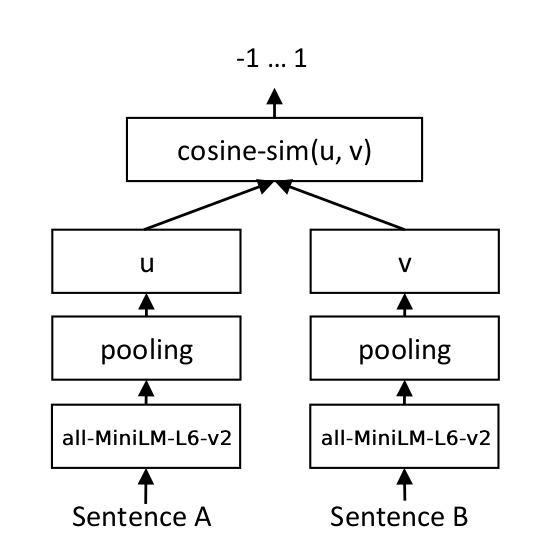

Defiing `mean pooling` function

In [ ]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 384. -dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()

    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [ ]:
samples = []
for row in tqdm(dataset):
  samples.append(InputExample(
      texts=[row['premise'], row['hypothesis']]
  ))

  0%|          | 0/5608 [00:00<?, ?it/s]

## Compiling Torch Model

In [ ]:
BATCH_SIZE = 32
loader = st_datasets.NoDuplicatesDataLoader(samples, batch_size=BATCH_SIZE)

In [ ]:
minilm = models.Transformer('sentence-transformers/all-MiniLM-L6-v2')

pooling = models.Pooling(minilm.get_word_embedding_dimension(),
                         pooling_mode_mean_tokens=True)

model = SentenceTransformer(modules=[minilm, pooling], device='cuda')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

Adding Multiple Negative Ranking Loss

In [ ]:
loss = losses.MultipleNegativesRankingLoss(model)

## Training

In [ ]:
EPOCHS = 30
WARMUP = int(0.1 * len(loader))

In [ ]:
MODEL_OUTPUT_PATH = 'embedding_model/minilm_gita'

In [ ]:
model.fit(
    train_objectives=[(loader, loss)],
    epochs=EPOCHS,
    warmup_steps=WARMUP,
    output_path=MODEL_OUTPUT_PATH,
    show_progress_bar=True
)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

## Evalutation

Generating Embeddings

In [ ]:
sentences = dataset_df.premise[:5].to_list() + dataset_df.hypothesis[:5].to_list()
sentences

['What is the shloka in sanskrit of Chapter 18 Verse 1',
 'What is the verse in sanskrit of Chapter 18 Verse 1',
 'What is the verse in English of Chapter 18 Verse 1',
 'What is the shloka in English of Chapter 18 Verse 1',
 'What does  18 Verse 1 say?',
 'अर्जुन उवाच\n\nसंन्यासस्य महाबाहो तत्त्वमिच्छामि वेदितुम्।\n\nत्यागस्य च हृषीकेश पृथक्केशिनिषूदन।।18.1।।\n ',
 'अर्जुन उवाच\n\nसंन्यासस्य महाबाहो तत्त्वमिच्छामि वेदितुम्।\n\nत्यागस्य च हृषीकेश पृथक्केशिनिषूदन।।18.1।।\n ',
 'arjuna uvācha\nsannyāsasya mahā-bāho tattvam ichchhāmi veditum\ntyāgasya cha hṛiṣhīkeśha pṛithak keśhi-niṣhūdana\n',
 'arjuna uvācha\nsannyāsasya mahā-bāho tattvam ichchhāmi veditum\ntyāgasya cha hṛiṣhīkeśha pṛithak keśhi-niṣhūdana\n',
 'The sentence in English translation is:\n\n"The body is the field, the ten senses are the ten bulls that work unceasingly day and night through the field of objects of the senses. The mind is the supervisor, the individual soul is the tenant, the five vital airs are the five labor

In [ ]:
embeddings = model.encode(sentences)
embeddings

array([[-0.15453929,  0.12307183,  0.08608478, ...,  0.2626678 ,
         0.21239717,  0.17097785],
       [-0.17996472,  0.08909022,  0.08767601, ...,  0.27888316,
         0.22623459,  0.12810263],
       [-0.1337329 ,  0.31806213,  0.541495  , ...,  0.20076305,
         0.27555013,  0.03535153],
       ...,
       [ 0.11140421,  0.26880464,  0.043184  , ...,  0.16528636,
         0.10003042,  0.23374625],
       [ 0.11140421,  0.26880464,  0.043184  , ...,  0.16528636,
         0.10003042,  0.23374625],
       [-0.11003613,  0.03355889,  0.12110304, ...,  0.02947788,
         0.07242699,  0.02766934]], dtype=float32)

## Evaluation

Constructing Similarity Matrix

In [ ]:
import numpy as np
from sentence_transformers.util import cos_sim

def sim_matrix(model):
  sim = np.zeros((len(sentences), len(sentences)))
  for i in range(len(sentences)):
      sim[i:, i] = cos_sim(
          embeddings[i], embeddings[i:]
      )
  return sim

Plotting Similarity Matrix

<Axes: >

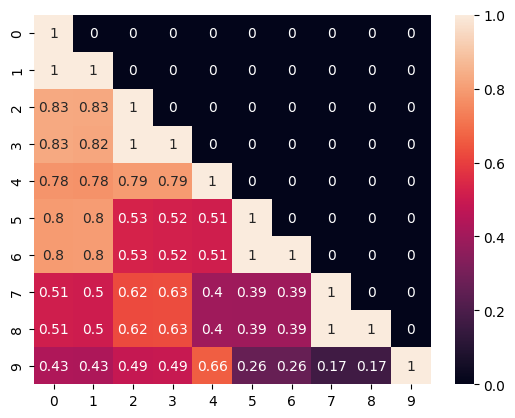

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sim = sim_matrix(model)
sns.heatmap(sim, annot=True)